# Determining optimal thresholds for the tracker function
The floe tracking functionality uses a set of similarity metrics find the best matches between pairs of ice floes observed in different images. The first step is to filter the list of candidate floes by a time-dependent travel distance threshold. In this notebook, we examine the uncertainty in floe similarity metrics as a function of the floe shape and size, in order to determine the best choices of thresholds. Define the normalized absolute difference between X and Y as
$$ AD(X, Y) = \frac{2|X - Y|}{X + Y} $$
We can then define the following metrics for a pair of floes $f$ and $g$:

* $AD_{area} = AD(\mbox{area}(X), \mbox{area}(Y))$
* $AD_{convex} = AD(\mbox{convex\_area}(X), \mbox{convex\_area}(Y))$
* $AD_{axmin} = AD(\mbox{axis\_minor\_length}(X), \mbox{axis\_minor\_length}(Y))$
* $AD_{axmin} = AD(\mbox{axis\_major\_length}(X), \mbox{axis\_major\_length}(Y))$

For the ice floes with sufficient scores on the similarity metrics, additional measurements are taken based on the properties of the boundaries and the match score after optimal rotation. The QuadDIRECT (QD) algorithm is used to find the optimal rigid registration (shift + rotation) of a pair of images, optimized by minimizing the mean square error between the original image and the transformed image. For binary images, the error is equivalent to the recall (TBD: verify this! Could be a function of Re instead of actually Re). The (normalized) symmetric difference measures the area where the two objects don't match.

* $\psi\mbox{-}s$ curve correlation
* $Re(X, Y) = \frac{\mbox{area}(X \cap Y)}{\mbox{area}(X)}$
* $SD(X,Y) = \mbox{area}(X \setminus \, Y) \cup \mbox{area}(Y \setminus X)$
* Normalized $SD(X, Y) = SD(X, Y)/\mbox{area}(X)$

For $Re$ and $SD$, we take the measure between the source floe and the candidate match _after_ rotation. So letting $R_\theta$ be the rotation operator, and considering $X$ the source and $Y$ the candidate match, we compute the measures with $R_\theta Y$ instead of $Y$.

# Experiment
Even with optimal ice floe identification, measures of object properties from a discretzed, binary representation of an object will  have inherent uncertainty. To quantify the uncertainty, we use manually identified ice floe labels, and carry out an experiment in which we vary the object orientation and test the difference in each measure. 

* Rotation, original size. For each rotation $\theta$, we compute shape measures, the 4 ratios and the psi-s correlation, then we use the QD algorithm to estimate the rotation angle. We record $\hat \theta$ and the computed mismatch $mm$, and manually compute $Re(X, R_\hat{\theta} Y)$, and the normalized $SD(X, R_\hat{\theta})$.
* We also compute downsampled versions of each shape and rotated shape by scaling the shape to 1/2 size and 1/4 size. The scaling is done after the rotation, to simulate the effect of a true rotated shape being discretized by a low-resolution sensor, as opposed to adding error from rotating a discretized shape.

In [1]:
using Pkg;
Pkg.activate("calval")
# Pkg.precompile()
# Pkg.instantiate()

using IceFloeTracker
using IceFloeTracker: load, regionprops_table, label_components, imshow, absdiffmeanratio, mismatch
using DataFrames, Statistics, CSV, Dates, Plots, Interpolations, Images

  Activating project at `~/Documents/research/manuscripts/cal-val_ice_floe_tracker/calval_tgrs/notebooks/calval`
/Users/dwatkin2/.julia/conda/3/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


We're going to use some images in the test_images folder. Starting with one is fine. The aim is to have a function where we can
* import the image
* select the large-enough floes
* for each floe, compute the rotations
* for each floe and each rotation, compute the downsampled sizes
* compute the measures, ratios, and rotations
* save the results to a CSV for analysis

In [38]:
greaterthan0(x) = x .> 0 # convert labeled image to boolean
greaterthan05(x) = x .> 0.5 # used for the image resize step

# Load the images from file
# fname = "001-baffin_bay-20220911-aqua-labeled_floes.png"
test_images_loc = "../data/test_images_tracker_setup/"
# image = load(joinpath(test_images_loc, fname))
        
# Add labels and get region properties
# labeled_image = label_components(image);
# props = regionprops_table(labeled_image);
props = []
labeled_images = []
for fname in ["001-baffin_bay-20220911-aqua-labeled_floes.png",
              "022-barents_kara_seas-20060909-aqua-labeled_floes.png"]
    image = load(joinpath(test_images_loc, fname))
        
    # Add labels and get region properties
    labeled_image = label_components(image)
    push!(labeled_images, labeled_image)
    props_table = regionprops_table(labeled_image)
    IceFloeTracker.addfloemasks!(props_table, greaterthan0.(labeled_image))
    push!(props, props_table)        
    # append!(props, IceFloeTracker.addfloemasks!(props_table, greaterthan0.(labeled_image)))
end

In [6]:
 all_props = reduce(vcat, props);
# Not sure the best way to call this function
IceFloeTracker.addψs!([all_props]);

In [7]:
size(all_props)

(87, 13)

In [10]:
# IceFloeTracker.addfloemasks!(props, greaterthan0.(labeled_image));

In [81]:
# compute_ratios((props_day1, r), (props_day2,s))
n = size(all_props)[1]
N = Int(round(1/2*n*(n-1)))
ad_area1 = zeros(N)
ad_maj1 =  zeros(N)
ad_min1 = zeros(N)
ad_con1 = zeros(N)
c = 1
for i in range(1, n)
    for j in range(1, i-1)
        area, majoraxis, minoraxis, convex_area = IceFloeTracker.compute_ratios((all_props, i), (all_props, j));
        ad_area1[c] = area
        ad_maj1[c] = majoraxis
        ad_min1[c] = minoraxis
        ad_con1[c] = convex_area
        c += 1
    end
end

In [86]:
N
sort(ad_area1)[1:1000:end]

49-element Vector{Float64}:
 0.0
 0.031413612565445025
 0.06369426751592357
 0.09665427509293681
 0.12987012987012986
 0.16560509554140126
 0.20224719101123595
 0.23529411764705882
 0.26666666666666666
 0.30057803468208094
 0.32967032967032966
 0.3614457831325301
 0.39593908629441626
 ⋮
 1.3147023086269745
 1.36
 1.4072345390898484
 1.4526315789473685
 1.5
 1.552
 1.6030075187969925
 1.6595744680851063
 1.714902807775378
 1.7731442869057548
 1.8388059701492536
 1.920704845814978

In [104]:
all_props[isequal.(all_props.area, 43), :]

Row,area,min_row,min_col,max_row,max_col,row_centroid,col_centroid,convex_area,major_axis_length,minor_axis_length,orientation,perimeter,mask
,Float64,Int64,Int64,Int64,Int64,Any,Any,Float64,Float64,Float64,Float64,Float64,Any
1,43.0,266,181,272,188,269,185,43.0,7.82671,7.01012,-1.51066,21.3137,Bool[0 0 … 0 0; 0 0 … 1 0; … ; 0 1 … 1 1; 0 0 … 1 0]
2,43.0,283,267,290,273,286,270,45.0,8.45407,6.46936,-0.32327,21.8995,Bool[0 0 … 1 0; 0 1 … 1 1; … ; 0 1 … 1 0; 0 0 … 0 0]
3,43.0,44,323,49,331,47,327,45.0,9.02909,6.10195,1.43693,22.4853,Bool[0 0 … 0 0; 0 1 … 0 0; … ; 0 1 … 1 1; 0 1 … 1 0]
4,43.0,195,349,202,355,198,352,45.0,8.09021,6.85365,-0.390712,21.8995,Bool[0 1 … 0 0; 0 1 … 1 0; … ; 1 1 … 0 0; 0 1 … 0 0]
5,43.0,197,366,204,373,200,369,45.0,8.38969,6.63662,-0.730759,22.7279,Bool[0 0 … 0 0; 0 1 … 1 0; … ; 0 1 … 0 0; 0 0 … 0 0]


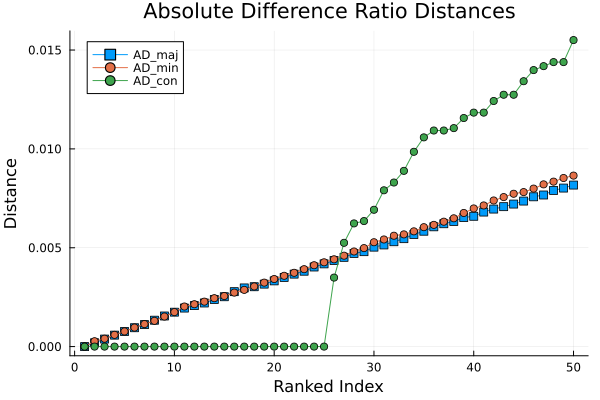

In [115]:
plot(sort(ad_area1)[1:10:500], label="AD_area", m=:square)
plot(sort(ad_maj1)[1:10:500], label="AD_maj", m=:square)
plot!(sort(ad_min1)[1:10:500], label="AD_min", m=:circle)
plot!(sort(ad_con1)[1:10:500], label="AD_con", m=:circle)
plot!(ylabel="Distance", xlabel="Ranked Index", title="Absolute Difference Ratio Distances")

In [69]:
import Pkg;
Pkg.add("Statistics")

   Resolving package versions...
    Updating `~/Documents/research/manuscripts/cal-val_ice_floe_tracker/calval_tgrs/notebooks/calval/Project.toml`
  [10745b16] + Statistics v1.11.1
    Updating `~/Documents/research/manuscripts/cal-val_ice_floe_tracker/calval_tgrs/notebooks/calval/Manifest.toml`
  [05823500] ↑ OpenLibm_jll v0.8.1+2 ⇒ v0.8.1+4
Precompiling project...
    641.1 ms  ✓ StringDistances
   1422.0 ms  ✓ TestImages
  2 dependencies successfully precompiled in 3 seconds. 371 already precompiled.


In [71]:
using Statistics

In [109]:
cor(ad_area1, ad_con1)

0.9983052725607984

In [110]:
cor(ad_area1, ad_maj1)

0.9164543240267928

In [111]:
cor(ad_maj1, ad_min1)

0.8361746161860159

In [112]:
cor(ad_min1, ad_con1)

0.9199806300539122

# Rotation experiment
The full experiment is in `test_floe_shapes.jl`.

TBD items:
- New rotation function
- Function to align by centroid and calculate normalized shape difference
- Test the recall calculation

In [16]:
# Initialize dataframe
df = DataFrame(
               floe_id=Int16[],
               size=Float64[],
               rotation=Float64[],
               area=Float64[],
               convex_area=Float64[],
               major_axis_length=Float64[],
               minor_axis_length=Float64[],
               adr_area=Float64[],
               adr_convex_area=Float64[],
               adr_major_axis_length=Float64[],
               adr_minor_axis_length=Float64[],
               est_rotation=Float64[],
               mismatch=Float64[],
               recall=Float64[],
               precision=Float64[],
               normalized_sd=Float64[]
               );

In [18]:
floe_data = all_props[1,:];

In [270]:
all_props[1:10,["area", "orientation"]]

Row,area,orientation
,Float64,Float64
1,612.0,0.709409
2,4088.0,1.1325
3,43.0,-1.51066
4,27.0,-1.44724
5,117.0,-0.856695
6,201.0,-1.02764
7,101.0,-1.52346
8,375.0,0.236758
9,92.0,-0.0610039


In [ ]:
"""
Align images by selecting and cropping so that r1, c1 and r2, c2 are the center.
These values are expected to be the (integer) centroid of the image. These images should
be already padded so that there is no danger of cutting into the floe shape.
"""
function crop_to_shared_centroid(im1, im2, r1, r2, c1, c2)
    if r1 == r2 && c1 == c2
        return im1, im2
    end
    
    n1, m1 = size(im1)
    n2, m2 = size(im2)
    new_halfn = minimum([minimum([r1, n1-r1]), minimum([r2, n1-r2])])
    new_halfm = minimum([minimum([c1, m1-c1]), minimum([c2, m2-c2])])

    # check notation: how does julia interpret start and end of array index?
    im1_cropped = im1[1+r1-new_halfn:r1 + new_halfn, 1 + c1-new_halfm:c1 + new_halfm]
    im2_cropped = im2[1+r2-new_halfn:r2 + new_halfn, 1 + c2-new_halfm:c2 + new_halfm]
    return im1_cropped, im2_cropped    
end

"""
Computes the shape difference between im_reference and im_target for each angle (degrees) in test_angles.
The reference image is held constant, while the target image is rotated. The test_angles are interpreted
as the angle of rotation from target to reference, so to find the best match, we rotate the reverse
direction. A perfect match at angle A would imply im_target is the same shape as if im_reference was 
rotated by A degrees.
"""
function shape_difference_rotation(im_reference, im_target, test_angles)
    shape_differences = zeros(size(test_angles))
    init_props = regionprops_table(label_components(im_reference))[1,:] # assumption only one object in image!
    idx = 1
    for angle in test_angles
        im_rotated = imrotate_bin(im_target, -angle)
        rotated_props = regionprops_table(label_components(im_rotated))[1,:]
        im1, im2 = crop_to_shared_centroid(im_reference,
                                           im_rotated,
                                           init_props.row_centroid,
                                           rotated_props.row_centroid,
                                           init_props.col_centroid,
                                           rotated_props.col_centroid)
        # Check here that im1 and im2 sizes are the same
        # Could also add check that the images are nonempty
        # These checks could go inside the crop_to_shared_ccentroid function
        if isequal.(prod(size(im1)), prod(size(im2)))
            a_not_b = im1 .> 0 .&& isequal.(im2, 0)
            b_not_a = im2 .> 0 .&& isequal.(im1, 0)
            shape_differences[idx] = sum(a_not_b .|| b_not_a)
        else
            print("Warning: shapes not equal")
            shape_differences[idx] = NaN
        end
        idx += 1
    end
    return shape_differences
end

In [ ]:
# Pad with zeros to allow rotation
init_floe = all_props[2, :mask]
n = Int64(round(maximum(size(init_floe))))
im_padded = collect(padarray(init_floe, Fill(0, (n, n), (n, n))))
print("Floe size: ", all_props[2, :area], " pixels")
imshow(im_padded.*255)

First guess: 90
Updated guess: 89.4

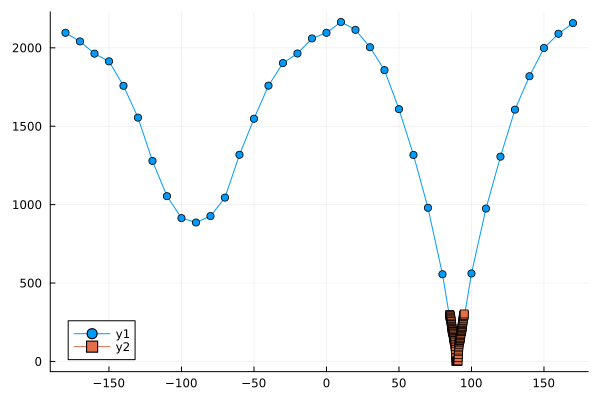

In [267]:
test_im = imrotate_bin(im_padded, 90);
# First do a full sweep
test_angles = range(-180, 170, step=10)
sd = shape_difference_rotation(im_padded, test_im, test_angles)
first_min = test_angles[argmin(sd)]
print("First guess: ", first_min, "\n")
plot(test_angles, sd, m=:circle)
# Then hone in on minimum
test_angles = range(floor(first_min - 5), ceil(first_min + 5), step = .1)
sd = shape_difference_rotation(im_padded, test_im, test_angles)
second_min = test_angles[argmin(sd)]
print("Updated guess: ", second_min)
plot!(test_angles, sd, m=:square)

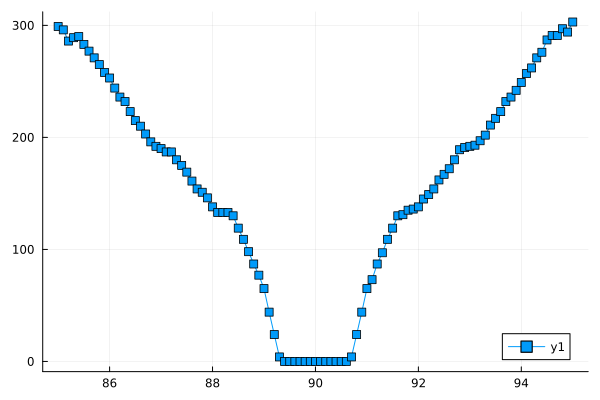

In [268]:
plot(test_angles, sd, m=:square)

0

10

In [224]:
using Plots

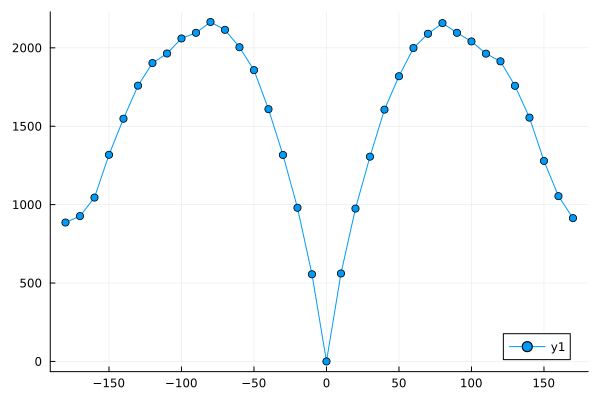

0

,,,,

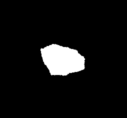
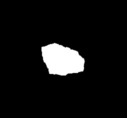
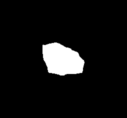
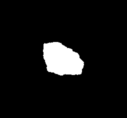
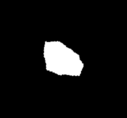

In [205]:
test_images = [imrotate_bin(im_padded, ang) for ang in [-10, -5, 0, 5, 10]]
imshow.(test_images)

,,,,,,

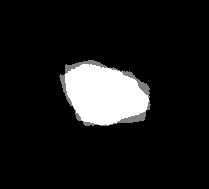
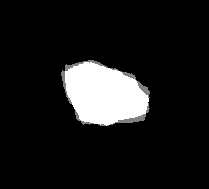
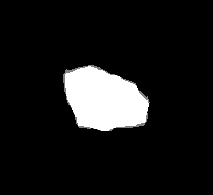
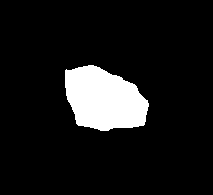
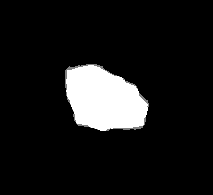
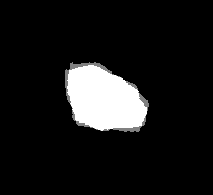
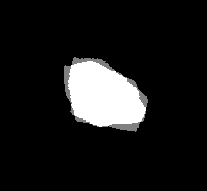

In [207]:
test_images = [imrotate_bin(im_padded, ang) for ang in [-15, -10, -5, 0, 5, 10, 15]]
overlay_images = []
init_props = regionprops_table(label_components(im_padded))[1,:]
shape_differences = []
for im in test_images
    rotated_props = regionprops_table(label_components(im))[1,:]
    im1, im2 = crop_to_shared_centroid(im_padded,
                                           im,
                                           init_props.row_centroid,
                                           rotated_props.row_centroid,
                                           init_props.col_centroid,
                                           rotated_props.col_centroid)
    push!(overlay_images, im1 .* 0.5 + im2 .* 0.5)
    a_not_b = im1 .> 0 .&& isequal.(im2, 0)
    b_not_a = im2 .> 0 .&& isequal.(im1, 0)
    push!(shape_differences, sum(a_not_b .|| b_not_a))
end
overlay_images = [x[20:end-20, 20:end-20] for x in overlay_images]
imshow.(overlay_images .* 255)

In [208]:
shape_differences

7-element Vector{Any}:
 780
 561
 303
   0
 299
 556
 773

In [268]:
typeof(padded_init)

OffsetMatrix{Bool, BitMatrix} (alias for OffsetArray{Bool, 2, BitArray{2}})

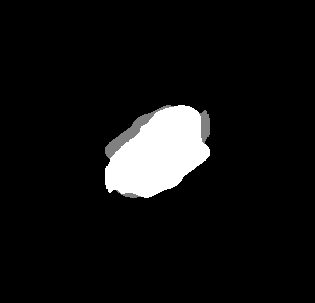

In [317]:
Gray.(im_scaled/2 + im_rotated)

In [329]:
a_not_b = (im_scaled .> 0) .& (greaterthan05(im_rotated) .== 0);
b_not_a = (im_scaled .== 0) .& (greaterthan05(im_rotated) .> 0);
sum(a_not_b .|| b_not_a)

1944

next steps:
- save results to CSV
- Examine statistics

- Error after best approximation rotation

In [278]:
fname = "021_flaskdjflkjasdf"
fname[1:3]

"021"

In [301]:
init_floe = copy(props[12, "mask"])
# pad the floe to avoid changing floe area relative to image size
n = Int64(round(maximum(size(init_floe))))
padded_init = collect(padarray(init_floe, Fill(0, (n, n), (n, n))))
example_images = []
for rotation in range(0, π, 6)
    new_size = trunc.(Int, size(padded_init) .* scale)
    im_rotated = imrotate(padded_init, rotation, axes(padded_init))
    im_rotated_scaled = greaterthan05(imresize(im_rotated, new_size))
    im_scaled = greaterthan05(imresize(padded_init, new_size))
    push!(example_images, im_rotated_scaled)
end

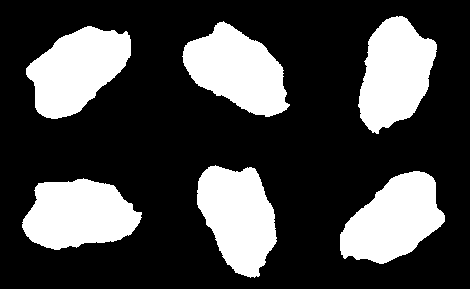

In [305]:
crop = 80
Images.mosaicview([Gray.(im[crop:end-crop, crop:end-crop]) for im in example_images], npad=1, nrow=2, fill=20)


In [275]:
sum(im_scaled .> 0), sum(im_rotated_scaled .> 0)

(503, 506)

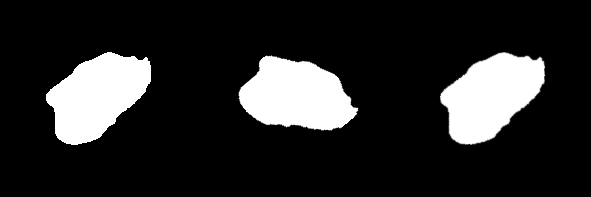

In [213]:
rotation = 50
imrotated = collect(imrotate(init_floe, deg2rad(rotation)));
mm, estimated_rotation = mismatch(init_floe, imrotated)
imrotated2 = collect(imrotate(imrotated, deg2rad(-estimated_rotation)));
Images.mosaicview([Gray.(init_floe), Gray.(imrotated), Gray.(imrotated2)], nrow=1)

In [187]:
mm, estimated_rotation = mismatch(im_scaled, im_scaled_rotated)
mm, estimated_rotation

(0.04796925126597019, 4.587694576707014)

In [208]:
size(init_floe), size(imrotated), size(imrotated2)

((93, 105), (141, 139), (197, 197))

In [165]:
sum(greaterthan05(imgw))

287

In [170]:
sum(greaterthan05(imrotate(props[12,:mask], 0)))

6219